# Block Ciphers: AES and Analyses

## Introduction

Block ciphers are fundamental tools in symmetric-key cryptography, offering data security by encrypting fixed-size blocks of plaintext using a symmetric key. They are a type of product cipher, combining confusion (non-linear substitution) and diffusion (linear transformation) as defined by Shannon. Among these, the Advanced Encryption Standard (AES) is the most widely adopted, approved by NIST in 2001 as a replacement for DES [1]. AES is regarded for its strong security, efficiency and resistance to known cryptanalytic attacks. It operates on 128-bit blocks and supports key sizes of 128, 192, or 256 bits.

This report explores the transformation steps of AES encryption. We also evaluate the algorithm’s strength through Shannon's principles of confusion and diffusion, using bit-flipping, Hamming distance and Monte Carlo simulation to analyse AES’s resistance to differential attacks, [2]. Additionally, we examine how AES operates in different modes (ECB, CBC, CFB, OFB), each providing unique methods for securely encrypting data depending on use case requirements.

In [1]:
from aes import AES

from diffusion_confusion import flip_bit, hamming_distance
from diffusion_confusion import aes_diffusion, aes_confusion

## AES 

AES encryption consists of a series of rounds (10 for 128-bit keys). AES achieves security through a series of well-defined transformations on the plaintext and the key —substitution, permutation, mixing, key addition and expansion— applied in a repeated round structure. Before the first round, a key addition is performed in which the plaintext is XORed with the first round key. These transformations provide both non-linearity and mixing, critical to cryptographic strength. Each round involves:

### Add Round Key

The AddRoundKey transformation is the first and last step in the AES round structure. It performs a bitwise XOR between the current 4x4 state matrix and a round-specific subkey generated through key expansion. This step is simple yet vital, as it introduces the key-dependent variation at every round, ensuring that the encryption is tied to the key. This step ensures that the ciphertext is dependent on the secret key from the very beginning,. Since XOR is its own inverse, this transformation is easily reversible during decryption [1].
It is important to note that the AddRoundKey step is positioned at the beginning because any transformations before it (or after the final AddRoundKey) can be trivially inverted without knowing the key. This means they do not contribute to the security of the cipher. 

### Substitution Bytes

The invertible SubBytes operation provides non-linearity to the cipher by substituting each byte of the state using a substitution box (S-box). This S-box is constructed using the multiplicative inverse over GF(2^8), followed by an affine transformation. It enhances resistance against linear and differential cryptanalysis by ensuring that small changes in input create unpredictable output differences, providing confusion [3].

### Shift Rows

ShiftRows is a permutation step that cyclically shifts each row of the state matrix to the left by a certain number of bytes: the second row by 1, the third by 2, and the fourth by 3 positions. This operation spreads the byte positions across columns, contributing to diffusion by ensuring that the effect of a single byte affects multiple columns over rounds [4].

### Mix Columns

The MixColumns step transforms each column of the state matrix using a fixed mathematical transformation over \( GF(2^8) \). Each column of four bytes is treated as a vector and is multiplied by a constant 4x4 matrix, mixing the bytes within the column. This process ensures that a change in one byte affects all four bytes in that column, providing strong diffusion. It is skipped in the final round to maintain efficient decryption without weakening security [1].


### Key Expansion

Key Expansion (also known as the key schedule) takes the original cipher key and expands it to generate round keys. The AES-128 Key Expansion (Key Schedule) generates 11 round keys, each consisting of four 32-bit words (44 words in total) from the initial 128-bit key. The first four words are directly taken from the original key. Subsequent words are generated iteratively. Specifically, every fourth word undergoes a transformation known as the g-function, which includes a cyclic left shift, byte substitution, and an XOR with a round-dependent constant (RC). This process ensures that each round of AES uses a unique 128-bit round key.

### Encryption

The encryption for 128-bit key process consists of:

*Initial key addition

*9 standard rounds consisting of byte substitution, row shifting, column mixing and key addition in this order

*Final round consists of byte substitution, row shifting, column mixing and key addition (no column mixing)

Each transformation plays a critical role in strengthening the cipher against various attacks, from linear cryptanalysis to differential cryptanalysis [4].
Each transformation plays a critical role in ensuring the cipher's security by introducing non-linearity, diffusion, and key dependence, effectively defending against attacks such as linear and differential cryptanalysis [4]

## AES Diffusion and Confusion

Claude Shannon emphasized two principles for secure cipher design: confusion, which hides the relationship between ciphertext and key, and diffusion, which spreads plaintext information across the ciphertext [2]. To test diffusion, a single-bit flip was introduced in the plaintext. The Hamming distance, which counts the differing bits between two binary strings of equal length, was used to measure the variation between the ciphertexts. A high Hamming distance indicates good diffusion, as the effect of the bit flip propagates through the entire block. Likewise, confusion was assessed by modifying a single bit in the key, observing how this change altered the ciphertext. 

### Monte Carlo Simulation

Monte Carlo Simulation (MCS) is a statistical technique that uses random sampling to approximate the probability distributions of outcomes, by performing many trial runs. It is widely used in cryptography to evaluate how secure a cipher is by analyzing its behavior under various conditions.  (Please note that we have the results discussed here saved in a pickle file.)

We conducted a Monte Carlo simulation with 1,000 trials for each round of AES (from 1 to 10 rounds) to analyze the confusion and diffusion properties of the cipher. In each trial, the Hamming distance was measured between ciphertexts under two scenarios: one where the plaintext differed by a single bit (diffusion) and another where the key differed by a single bit (confusion). The resulting distributions of Hamming distances for each round are shown in the histograms above. 

#### **Diffusion Results:**
- **Initial Round (1):** Diffusion is minimal, with an average Hamming distance of 16.2. This is expected since the impact of a single bit change in the plaintext has not yet fully propagated through the cipher's transformations.
- **Subsequent Rounds (2-10):** The Hamming distance rapidly increases to around 64 by the second round and remains stable in the following rounds, with a standard deviation of approximately 5.7. This indicates that the plaintext changes are spreading effectively, creating a complex dependency between the input and output.

#### **Confusion Results:**
- **Initial Round (1):** Confusion is limited, with a mean Hamming distance of 21.3, indicating that the relationship between the key and ciphertext is not yet fully complex.
- **Subsequent Rounds (2-10):** The Hamming distance quickly aligns with that of diffusion, stabilizing around 64 with a similar standard deviation. This demonstrates that a single-bit change in the key has a strong, unpredictable impact on the ciphertext by the second round.

#### **General Remarks:**
- The rapid increase in Hamming distance within the first two rounds shows that AES quickly achieves strong confusion and diffusion properties, which are critical for its security.
- The stabilization around 64 for both properties aligns with the theoretical expectation for a 128-bit block cipher, where on average, half of the bits (64 out of 128) should differ due to a single-bit change.
- The slight variation in standard deviation across rounds is expected due to the probabilistic nature of the Monte Carlo simulation but remains within a narrow range.

In [ ]:
import numpy as np
import pickle

# monte Carlo Simulation Function
def run_monte_carlo(function, num_rounds=None, num_trials=1000):
    distances = []
    for _ in range(num_trials):
        distance = function(num_rounds)
        distances.append(distance)
    
    return distances

num_trials = 1000 

# collecting results in lists
diffusion_results = []
confusion_results = []
results_stats = {"diffusion": {}, "confusion": {}}

for num_rounds in range(1, 11):
    # Diffusion Analysis
    diffusion_distances = run_monte_carlo(aes_diffusion, num_rounds, num_trials)
    diffusion_results.append(diffusion_distances)
    diffusion_mean = np.mean(diffusion_distances)
    diffusion_std = np.std(diffusion_distances)
    results_stats["diffusion"][num_rounds] = {
        "mean": diffusion_mean,
        "std": diffusion_std
    }
    
    # Confusion Analysis
    confusion_distances = run_monte_carlo(aes_confusion, num_rounds, num_trials)
    confusion_results.append(confusion_distances)
    confusion_mean = np.mean(confusion_distances)
    confusion_std = np.std(confusion_distances)
    results_stats["confusion"][num_rounds] = {
        "mean": confusion_mean,
        "std": confusion_std
    }

# save the results to a pickle file
with open("aes_results.pkl", "wb") as f:
    pickle.dump({
        "diffusion": diffusion_results, 
        "confusion": confusion_results, 
        "results_stats": results_stats
    }, f)

Results successfully loaded.


=== AES Diffusion and Confusion Statistics ===

Diffusion (Rounds=1) - Mean: 16.212, Std: 3.955383167279752
Diffusion (Rounds=2) - Mean: 64.198, Std: 8.235459671445183
Diffusion (Rounds=3) - Mean: 63.839, Std: 5.512084814296674
Diffusion (Rounds=4) - Mean: 63.987, Std: 5.693578048995201
Diffusion (Rounds=5) - Mean: 64.140, Std: 5.628356776182548
Diffusion (Rounds=6) - Mean: 64.211, Std: 5.797282035574947
Diffusion (Rounds=7) - Mean: 64.362, Std: 5.695871838445805
Diffusion (Rounds=8) - Mean: 64.058, Std: 5.777597770700207
Diffusion (Rounds=9) - Mean: 64.263, Std: 5.782718305433872
Diffusion (Rounds=10) - Mean: 64.156, Std: 5.412916404305538
Confusion (Rounds=1) - Mean: 21.364, Std: 6.308050729028738
Confusion (Rounds=2) - Mean: 63.916, Std: 6.270003508770948
Confusion (Rounds=3) - Mean: 64.165, Std: 5.549754499074711
Confusion (Rounds=4) - Mean: 63.942, Std: 5.756790425228280
Confusion (Rounds=5) - Mean: 63.987, Std: 5.691821413220903
Confusion (Rounds=6)

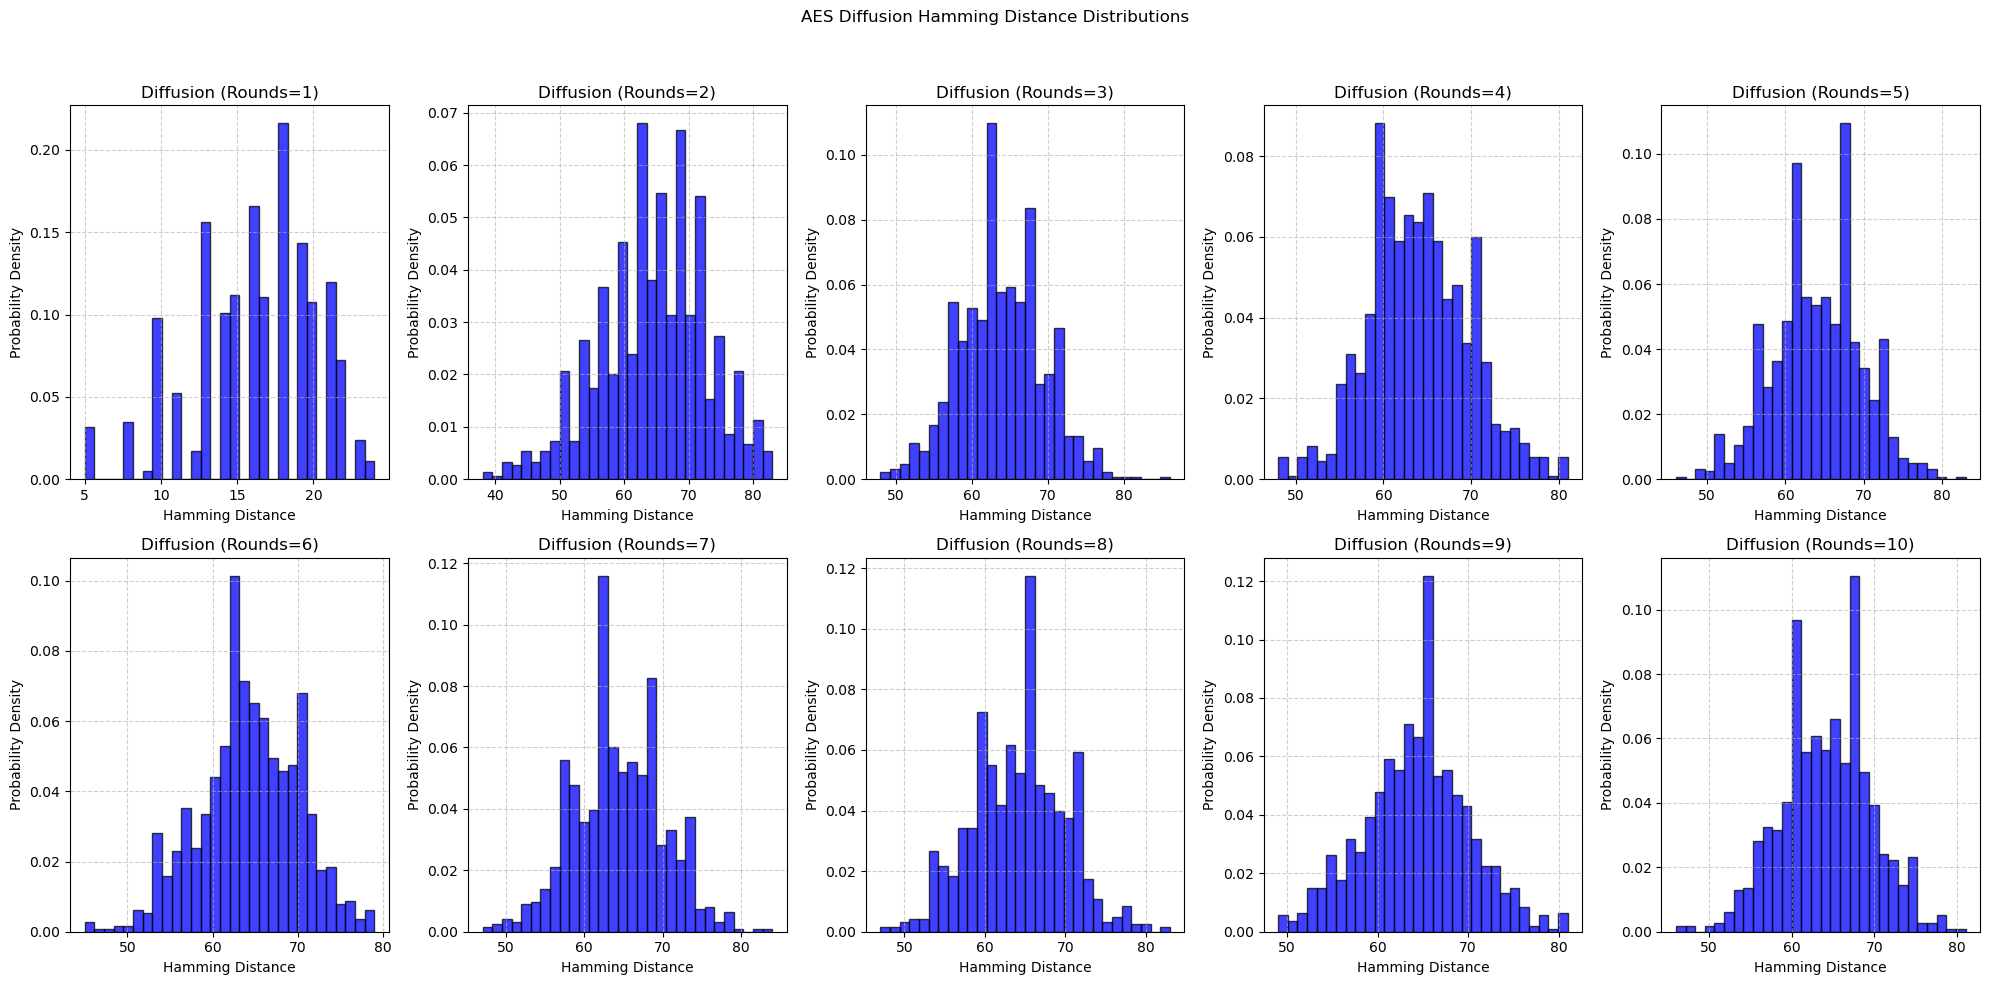

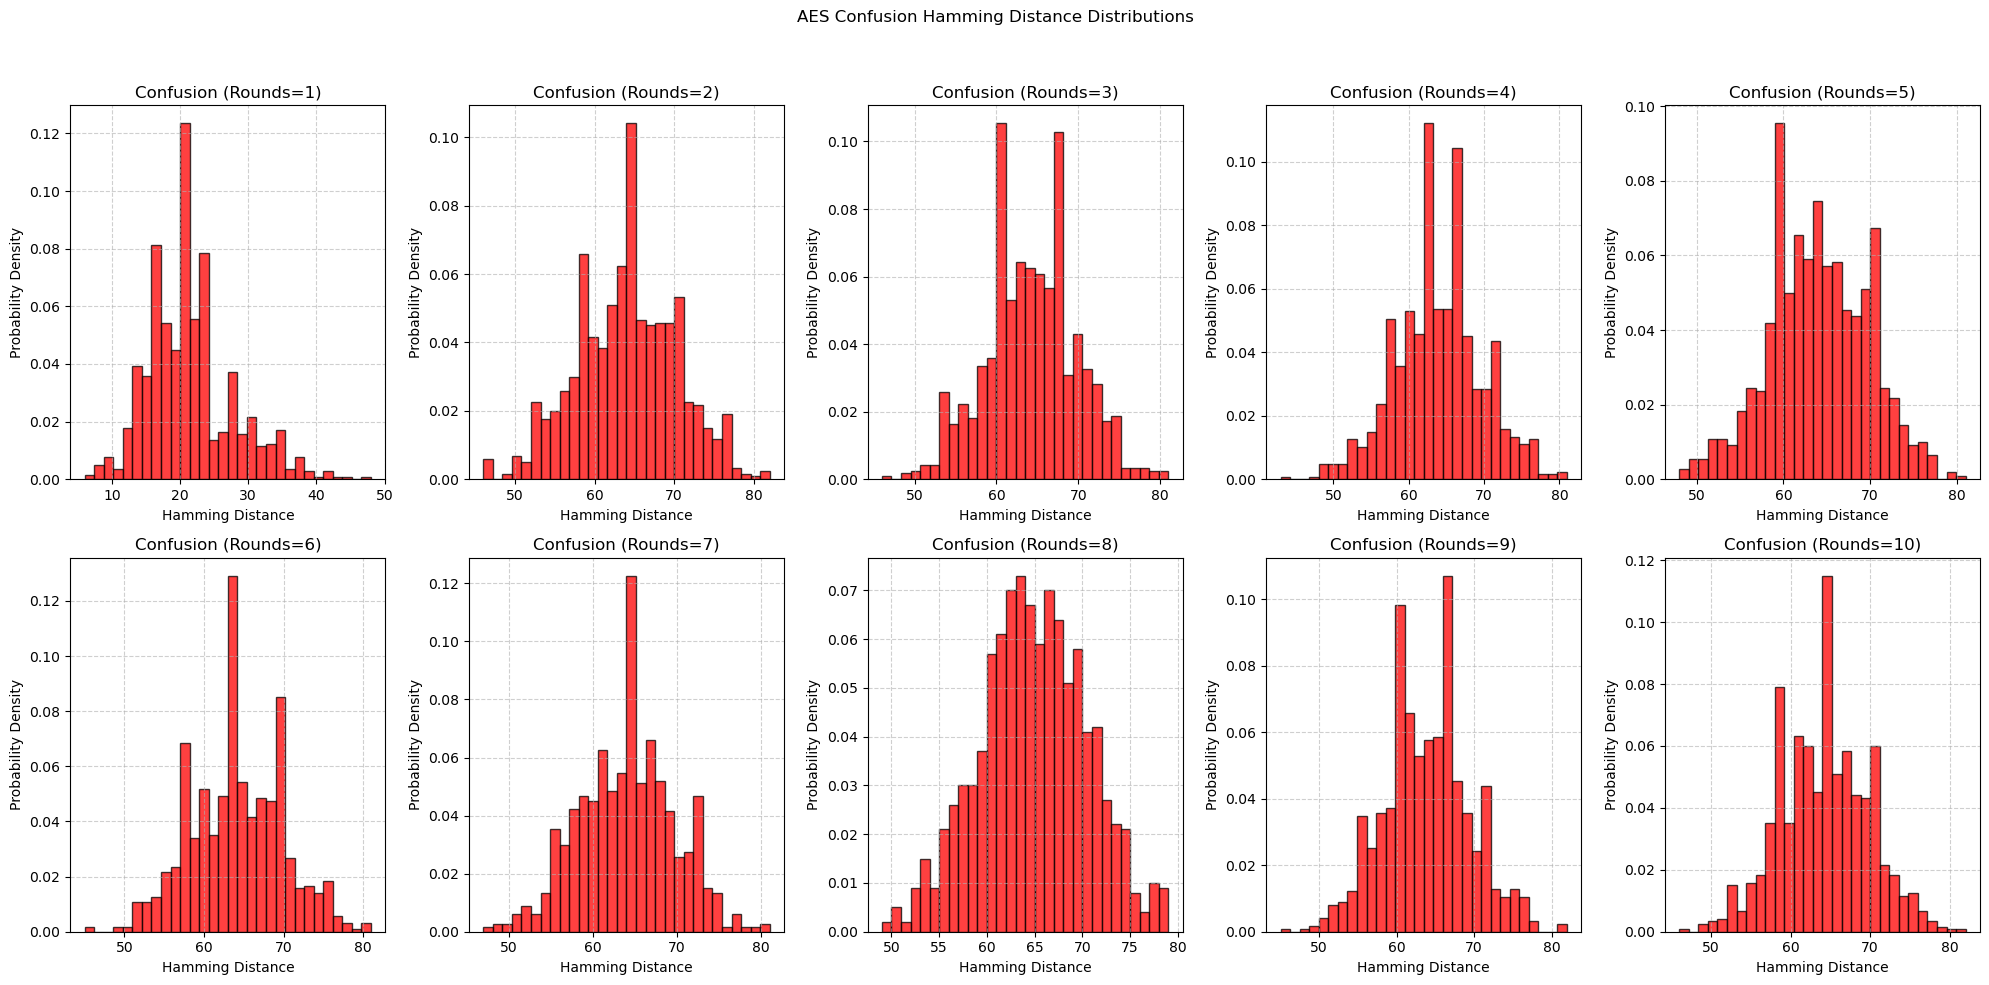

In [ ]:
import pickle
import matplotlib.pyplot as plt

# load the AES results from the pickle file
with open("aes_results.pkl", "rb") as file:
    aes_results = pickle.load(file)

# extracting diffusion, confusion results, and statistics
diffusion_results = aes_results.get("diffusion")
confusion_results = aes_results.get("confusion")
results_stats = aes_results.get("results_stats", {})

if diffusion_results and confusion_results:
    print("Results successfully loaded.\n")
else:
    print("Error: Results could not be loaded. Please check the pickle file.")

# print the stored statistics
print("\n=== AES Diffusion and Confusion Statistics ===\n")
for mode in ["diffusion", "confusion"]:
    for round_num in range(1, 11):
        stats = results_stats.get(mode, {}).get(round_num, {})
        if stats:
            mean = stats.get("mean", 0)
            std = stats.get("std", 0)
            print(f"{mode.capitalize()} (Rounds={round_num}) - Mean: {mean:.3f}, Std: {std:.15f}")

def plot_diffusion(distances_list):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    fig.suptitle("AES Diffusion Hamming Distance Distributions")

    for num_rounds in range(1, 11):
        ax = axes[(num_rounds - 1) // 5, (num_rounds - 1) % 5]
        distances = distances_list[num_rounds - 1]
        ax.hist(distances, bins=30, alpha=0.75, edgecolor='black', color='blue', density=True)
        ax.set_title(f"Diffusion (Rounds={num_rounds})")
        ax.set_xlabel("Hamming Distance")
        ax.set_ylabel("Probability Density")
        ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_confusion(distances_list):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    fig.suptitle("AES Confusion Hamming Distance Distributions")

    for num_rounds in range(1, 11):
        ax = axes[(num_rounds - 1) // 5, (num_rounds - 1) % 5]
        distances = distances_list[num_rounds - 1]
        ax.hist(distances, bins=30, alpha=0.75, edgecolor='black', color='red', density=True)
        ax.set_title(f"Confusion (Rounds={num_rounds})")
        ax.set_xlabel("Hamming Distance")
        ax.set_ylabel("Probability Density")
        ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_diffusion(diffusion_results)
plot_confusion(confusion_results)


## Bonus: AES Decryption and the BlockCipher Class

### Decryption

AES decryption is the reverse of the encryption process, carefully applying the inverse transformations of each encryption step. It begins with an initial AddRoundKey using the final round key. Then, it performs Inverse ShiftRows and Inverse SubBytes, reversing the final round of encryption. Then, it undoes the standard rounds of encryption process by applying the inverse of each operation. Inverse of the AddRoundKey is XORing with the key again, and a simple shift operation is performed for Inverse ShiftRows. Inverse byte substitution is a 2 step procedure but we implemented it as an inverse S-Box lookup table for faster implementation. For the Inverse MixColumns, each column is multiplied by the inverse of the matric used in MixColumnns. The reverse order ensures that the decryption process perfectly undoes the encryption, restoring the original plaintext.

### The BlockCipher Class

The BlockCipher class is a flexible implementation of a block cipher in Python, capable of supporting various modes of operation for symmetric encryption. When initialized, it takes a key, an optional initialization vector (IV), a specific encryption algorithm (defaulting to AES), and a mode of operation (defaulting to ECB). This setup allows the class to work with multiple encryption methods, depending on the mode chosen; ECB, CBC, CFB, and OFB.

The class includes methods for padding and unpadding plaintext to ensure that it aligns with the block size (typically 16 bytes for AES), using a padding scheme like PKCS7. It also has dedicated methods for encryption and decryption, with the appropriate mode (ECB, CBC, CFB, or OFB) selected dynamically at runtime.

If an IV is not provided, it is randomly generated for modes that require it (CBC, CFB, and OFB), ensuring secure initialization. The design of the BlockCipher class makes it adaptable, allowing any block cipher algorithm (not just AES) to be easily integrated, making it a robust tool for secure encryption and decryption.


## Conclusion

In this report, we have explored the Advanced Encryption Standard (AES), exploring its components, including key expansion, encryption, decryption, and the role of confusion and diffusion in its security. Through our implementation, we have demonstrated how AES leverages multiple transformation layers—SubBytes, ShiftRows, MixColumns, and AddRoundKey—to achieve robust encryption. Our report further examined AES's resistance to cryptanalysis using Monte Carlo simulations, where the distribution of Hamming distances effectively showcased the increasing diffusion and confusion across rounds.

We also covered various modes of operation (ECB, CBC, CFB, OFB) for applying AES in different situations. The implementation of a BlockCipher class highlighted how AES can be adapted to these modes while using padding techniques to align plaintext with block size.

Overall, AES is a vital part of modern symmetric-key cryptography, offering a balance of security and efficiency. Its structured design, combining substitution, permutation, and key-dependent transformations, ensures resilience against known cryptographic attacks.

## References

[1] National Institute of Standards and Technology (NIST). FIPS PUB 197: Advanced Encryption Standard (AES). 2001.

[2] Shannon C. Communication theory of secrecy systems. Bell System Technical Journal. 1949;28(4):656–715.

[3] Daemen J, Rijmen V. The Design of Rijndael: AES—The Advanced Encryption Standard. Springer-Verlag; 2002.

[4] Stallings W. Cryptography and Network Security: Principles and Practice. 8th ed. Pearson; 2023.

[5] National Institute of Standards and Technology. AES Known Answer Test Vectors. 2001.

[6] Paar C, Pelzl J. Understanding Cryptography: A Textbook for Students and Practitioners. 2nd ed. Springer; 2018.